# Detecting Short Tandem Repeats (STRs) in the *APC* gene
### BIO392 30.09.2022
Contact: Max Verbiest (maxadriaan.verbiest@uzh.ch)

The aim of this notebook is to detect where STRs occur in a reference DNA sequence, and filter out low-quality repeats. For this example, we will use the DNA sequence of the *APC* gene, which is often mutated in colorectal cancer.

### 1: Load required libraries and convenience functions

In [1]:
# pickle library is needed to load .pickle files
import pickle  

# numpy and pandas are libraries to work with structured data
import numpy as np
import pandas as pd
# matplotlib and seaborn are used for making plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")

# we also need some classes from TRAL, to work with repeats
from tral.repeat.repeat import Repeat
from tral.repeat_list.repeat_list import RepeatList
# script with some functions to make life easier
import str_utils

%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


### 2: Load the file with repeats
The 'APC_repeats.pickle' file contains the unfiltered output of several repeat detection algorithms, and was generated using TRALs repeat detection modules. We're not going to run the repeat detection ourselves today, as this part of TRAL has many dependencies and is quite tricky to set up properly. Today, we will focus on filtering this annotation down to a subset of high-confidence STRs, and write these to a file for later use.

In [2]:
with open("../data/repeats/APC_repeats.pickle", "rb") as f:
    APC_repeats = pickle.load(f)
    
APC_repeats = str_utils.sort_repeatlist(APC_repeats)
print(f"There are {len(APC_repeats.repeats)} tandem repeats detected in the APC gene before filtering.")

There are 6553 tandem repeats detected in the APC gene before filtering.


We just loaded TRALs repeat annotation of the *APC* gene into the variable 'APC_repeats', which is an instance of TRALs 'RepeatList' class. Repeats can be accessed through 'APC_repeats.repeats', which will return a list containing the repeats.
For example, the 17th entry in this list is an STR made up of 12 'A' nucleotides, which starts at the 298th position of the APC gene region:

In [3]:
print(APC_repeats.repeats[16])

> begin:298 l_effective:1 n:12 pvalue:0.0 divergence:1e-10 type:phylo_gap01
A
A
A
A
A
A
A
A
A
A
A
A


Using 'str_utils.plot_repeatlist()', we can have a look at the distribution of the different types of repeats that TRAL detected in the APC gene. 

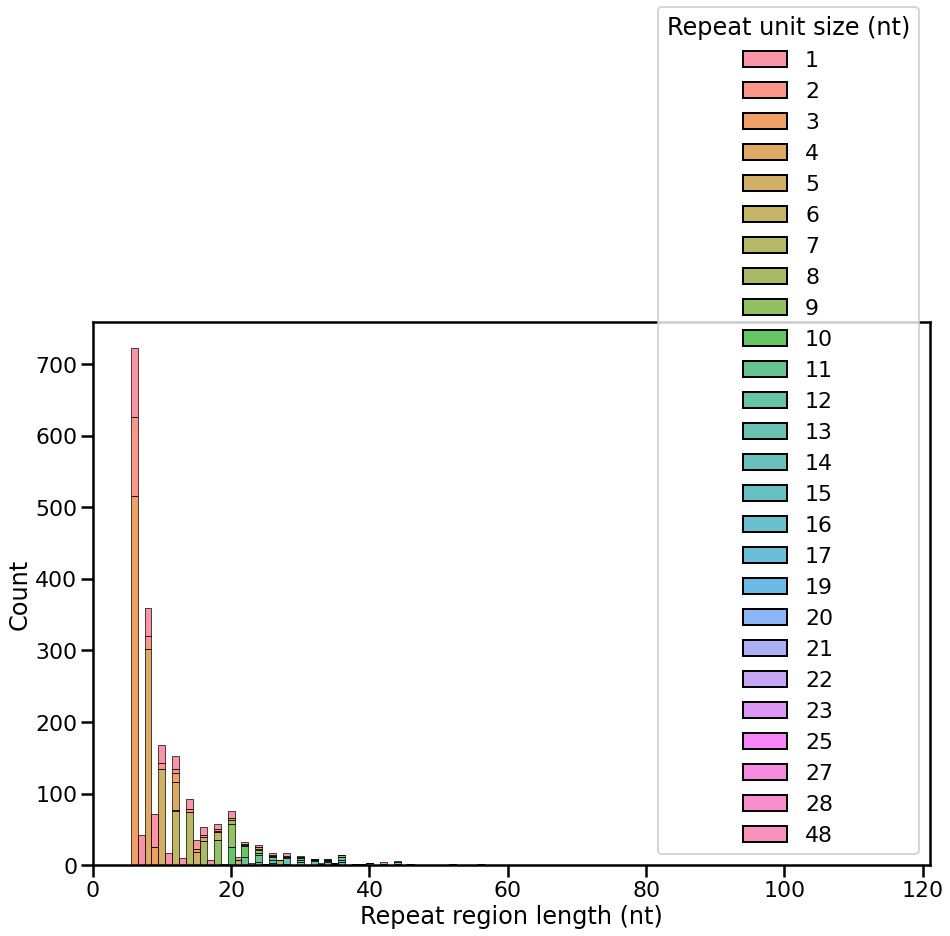

In [4]:
str_utils.plot_repeatlist(APC_repeats)


From the histogram, we can see that there are many non-STR tandem repeats with unit sizes > 6. Furthermore, there are also quite some 'low-quality' repeats, that have mismatches and indels between the different repeat units:

In [5]:
print(APC_repeats.repeats[25])

> begin:456 l_effective:7 n:3 pvalue:1.0 divergence:0.14703369147684325 type:phylo_gap01
TTTACCAT
TTT-CCAT
TCT----C


In fact, most of the repeats are not of the type we are interested in. Have a look at the first 5 entries in APC_repeats.repeats:

In [6]:
for i in range(5):
    print(APC_repeats.repeats[i], "\n")

> begin:15 l_effective:3 n:2 pvalue:0.0 divergence:1e-10 type:phylo_gap01
CAC
CAC 

> begin:30 l_effective:13 n:2 pvalue:1.0 divergence:0.31018066410046385 type:phylo_gap01
TGGTTCTCCAGCTTA
TGGATGGCAGATT-- 

> begin:44 l_effective:4 n:2 pvalue:0.0 divergence:1e-10 type:phylo_gap01
ATGG
ATGG 

> begin:54 l_effective:8 n:2 pvalue:1.0 divergence:0.1937255859987549 type:phylo_gap01
GA-TT-GTGG
GATTTCTTGG 

> begin:94 l_effective:3 n:15 pvalue:1.0 divergence:0.906036376953125 type:phylo_gap01
TT--
TTT-
ATA-
ATAA
ATC-
TCA-
TA--
TA--
TAT-
TCTA
GTG-
GTT-
CTG-
TTTC
TTT- 



### 3: Filtering the repeats
So, clearly, we need to filter our set of repeats down to a set of STRs that are likely to be affected by replication slippage, and the high mutability that is associated with STRs.

First of all, we will of course remove repeats whose motif is not 'short' enough: those where the repeating unit is longer than 6 nucleotides. Apart from this, TRAL also provides statistical frameworks to calculate scores for repeats. We will use the p-values and divergence scores from TRAL to select only the most high quality repeats. We will implement four filter criteria:
- Repeat unit length
- Repeat copy number (the number of units repeated in tandem)
- Repeat p-value (calculated using TRAL)
- Repeat divergence (calculated using TRAL)

In [7]:
# in this dictionary, every key represents a repeat unit size, and every value represents
# the minimum copy number that we require a repeat of that unit size to have
min_repeat_copies = {
    1: 9,
    2: 5,
    3: 4,
    4: 3,
    5: 3,
    6: 3
}
# the maximum values that we allow for a repeats p-value and divergence
max_pval = 0.05
max_div = 0.03

APC_repeats_filt = RepeatList(repeats=[])
for repeat in APC_repeats.repeats:
    if not str_utils.low_quality_repeat(repeat, max_pval, max_div, min_repeat_copies):
        APC_repeats_filt.repeats.append(repeat)

print(f"There are {len(APC_repeats_filt.repeats)} STRs detected in the APC gene after filtering.")

There are 126 STRs detected in the APC gene after filtering.


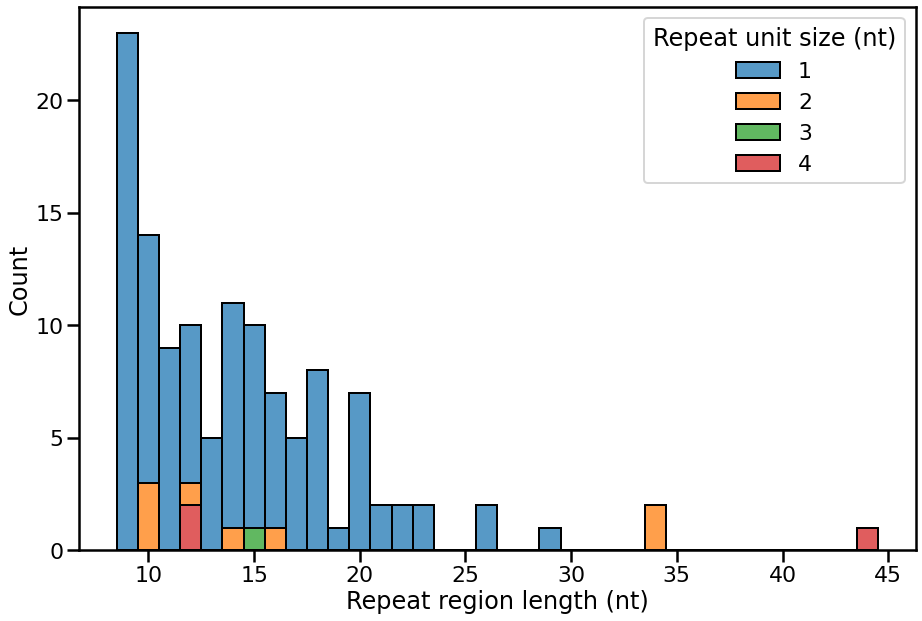

In [8]:
str_utils.plot_repeatlist(APC_repeats_filt)


Have a look at the histogram above. How does it differ from the graph we made for the unfiltered data? Also take some time to check the repeats in the new 'APC_repeats_filt', how do they look compared to the repeats we saw before the filtering?

In [15]:
# Task: print some repeats from APC_repeats_filt.repeats, compare them to those in APC_repeats.repeats

# str_utils.plot_repeatlist(APC_repeats_filt)
# str_utils.plot_repeatlist(APC_repeats)
# the count is much smaller, we filtered out many repeats with short repeat region length as well as the big unit sizes


print(APC_repeats_filt.repeats[30])
print(APC_repeats_filt.repeats[10])
print(APC_repeats_filt.repeats[20])

print(APC_repeats.repeats[30])
print(APC_repeats.repeats[10])
print(APC_repeats.repeats[20])

#the repeats after filtering look way more legit and shorter

> begin:46982 l_effective:1 n:23 pvalue:0.0 divergence:1e-10 type:phylo_gap01
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
> begin:16887 l_effective:1 n:11 pvalue:0.0 divergence:1e-10 type:phylo_gap01
T
T
T
T
T
T
T
T
T
T
T
> begin:25452 l_effective:1 n:11 pvalue:0.0 divergence:1e-10 type:phylo_gap01
A
A
A
A
A
A
A
A
A
A
A
> begin:559 l_effective:3 n:3 pvalue:1.0 divergence:0.12060546882587891 type:phylo_gap01
CCT
CCT
C--
> begin:171 l_effective:13 n:3 pvalue:1.0 divergence:0.2756347656698731 type:phylo_gap01
CATTTTCATATGTAC
CATTTCATTTAAT--
CCT------------
> begin:382 l_effective:17 n:2 pvalue:1.0 divergence:0.22680664067963868 type:phylo_gap01
TTTCAAAATACTTCCCCA
TTTCACAAACCTTCAGTG


The STRs in the filtered data should (hopefully) look a lot better than it did before. There are, however, still some final things to address before we can use our repeat annotations. For example, take a look at the following to STRs in 'APC_repeats_filt':

In [16]:
for repeat in APC_repeats_filt.repeats:
    if repeat.begin == 104055:
        print(repeat)

> begin:104055 l_effective:4 n:11 pvalue:0.0 divergence:0.018066406346386718 type:phylo_gap01
TTTA
TTTA
TTTA
TTTA
TTTA
TTTA
TTTA
TTTA
TTTA
TTTA
TT--
> begin:104055 l_effective:4 n:11 pvalue:0.0 divergence:0.01745605478400879 type:phylo_gap01
TTTA
TTTA
TTTA
TTTA
TTTA
TTTA
TTTA
TTTA
TTTA
TTTA
TTGA


We have to different annotations for the STR starting at position 104055! There are actually more examples of this in the filtered data, feel free to look for them. The annotations in this example are nearly identical, only the last unit is different. Why do you think we have this overlapping annotation?

In [22]:
# Task: write a short explanation for why there are overlapping entries. 
# the filtering is too specific, it assesses the repeat with TT-- as a different repeat than the one with TTGA 
#or maybe they are repeats that overlap

# BONUS: look for all overlapping entries in APC_repeats_filt.repeats



### 4: Clustering overlapping repeats

Luckily, TRAL provides methods to remove overlapping repeat annotations, while keeping only the most 'high-quality' repeat in case of conflicting annotations.

Which of the two overlapping STRs that start at position 104055 do you expect to be kept, and which to be removed? Why?

In [28]:
# Task: write which STR out of the example above you expect to be removed, and which to be kept. 
# Why do you think this?
#the one which ends with TTGA, because TT-- could be an error in sequencing and TTGA looks more like the actual repeat


In [17]:
APC_repeats_filt_clust = APC_repeats_filt.filter(
    "none_overlapping", 
    ["common_ancestry"], 
    [("pvalue", "phylo_gap01"), ("divergence", "phylo_gap01")]
)
APC_repeats_filt_clust = str_utils.sort_repeatlist(APC_repeats_filt_clust)

print(f"There are {len(APC_repeats_filt_clust.repeats)} STRs detected in the APC gene after filtering and clustering.")


There are 90 STRs detected in the APC gene after filtering and clustering.


Let's see which of the two STRs from the previous example are still present after clustering:

In [18]:
for repeat in APC_repeats_filt_clust.repeats:
    if repeat.begin == 104055:
        print(repeat)

> begin:104055 l_effective:4 n:11 pvalue:0.0 divergence:0.01745605478400879 type:phylo_gap01
TTTA
TTTA
TTTA
TTTA
TTTA
TTTA
TTTA
TTTA
TTTA
TTTA
TTGA


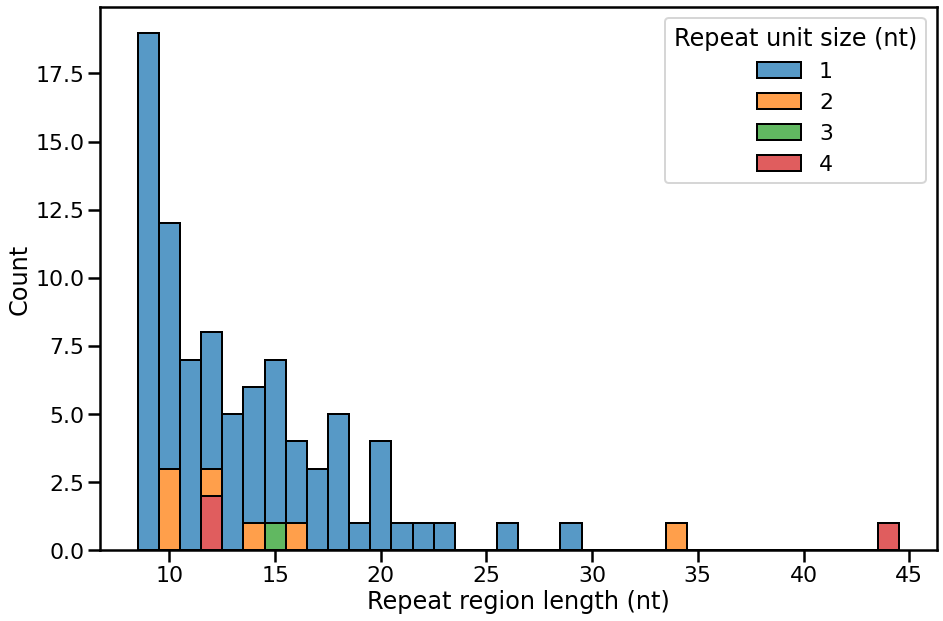

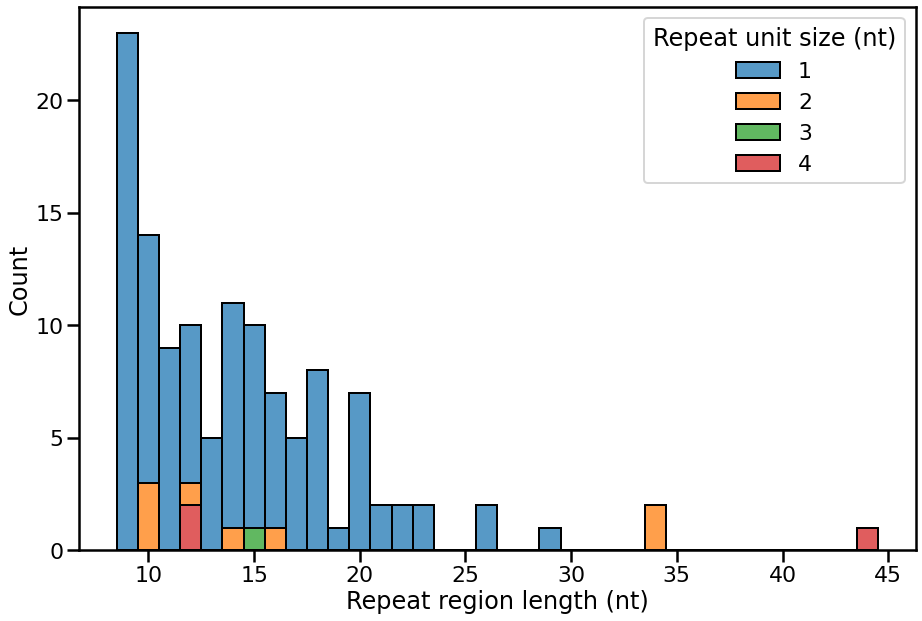

In [22]:
str_utils.plot_repeatlist(APC_repeats_filt_clust)
str_utils.plot_repeatlist(APC_repeats_filt)



The histogram of clustered repeats should be very similar to the previous one, except that the counts are slightly lower due to the removal of redundant entries.

### 5: Saving the repeats

We are first going to convert our TRAL RepeatList to a pandas DataFrame in a convenient format, which we will then save for later use.

As a sidenote: pandas is a Python library to work with data in a structured format (mostly as through the pandas DataFrame class). Pandas uses highly optimized C libraries behind the scenes to make working with this type of data fast and convenient. If you are interested in using Python for data sciences purposes, it is highly recommended to get familiar with pandas (and numpy, seaborn...).

In [23]:
# convert TRAL RepeatList to pandas DataFrame
df_repeats = str_utils.repeat_list_to_df(APC_repeats_filt_clust)
df_repeats

,chr,start,end,unit_len,unit
0,chr5,298,309,1,A
1,chr5,7241,7249,1,A
2,chr5,9390,9399,1,A
3,chr5,10062,10077,1,T
4,chr5,10673,10688,1,A
...,...,...,...,...,...
85,chr5,133075,133092,1,T
86,chr5,133512,133537,1,T
87,chr5,133668,133681,1,C
88,chr5,137481,137490,2,AG


In [25]:
# we will save our file in TSV format, which we need later on by GangSTR
df_repeats.to_csv("../data/repeats/APC_repeats.tsv", index=False, header=False, sep="\t")